### Install transformers library

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 15.6MB/s 
     |████████████████████████████████| 890kB 35.7MB/s 
     |████████████████████████████████| 2.9MB 51.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b77ccb61c07e2d3a58ecf67a41f17cb7d95c43ca2f2ba85b621b40a6ce0d1419
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Essential libraries imported

In [ ]:
import json,torch,time,pickle
import matplotlib.pyplot as plt 
from pathlib import Path
from transformers import BertTokenizer,AutoTokenizer,AdamW,BertForQuestionAnswering,BertTokenizerFast
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount("/content/drive") 

Mounted at /content/drive


### Retrieve SQuAD 2.0 dataset

In [ ]:
!mkdir squad  
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

--2021-01-24 10:31:36--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M   257MB/s    in 0.2s    

2021-01-24 10:31:36 (257 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2021-01-24 10:31:36--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad/dev-v2.0.json’

squ

### Prepare GPU Cuda.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


### Obtain train and validation data (contexts,questions,answers) from json files

In [ ]:
def read_squad(path):
  path = Path(path)
  with open(path, 'rb') as f:
    squad_dict = json.load(f)

  contexts = []
  questions = []
  answers = []
  for group in squad_dict['data']:
    for passage in group['paragraphs']:
      context = passage['context']
      for qa in passage['qas']:
        question = qa['question']
        for answer in qa['answers']:
          contexts.append(context)
          questions.append(question)
          answers.append(answer)

  return contexts, questions, answers

# Obtain train contexts,questions and answers
train_contexts, train_questions, train_answers = read_squad('squad/train-v2.0.json')

# Obtain validaton contexts,questions and answers
val_contexts, val_questions, val_answers = read_squad('squad/dev-v2.0.json')

### Just a random printing for safety reasons



In [ ]:
def test_print(contexts,questions,answers):
  print("Contexts length:",len(contexts))
  print("Questions:",len(questions))
  print("Answers length:",len(answers))

  print("\n")
  display(contexts[0])  
  print("\n")
  display(questions[0])
  print("\n")
  display(answers[0])
  print("\n")

print("============================== Train Dataset ======================================\n")
test_print(train_contexts,train_questions,train_answers)
print("============================== Val Dataset =======================================\n")
test_print(val_contexts,val_questions,val_answers)

============================== Train Dataset ======================================

Contexts length: 86821
Questions: 86821
Answers length: 86821




'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

'When did Beyonce start becoming popular?'

{'answer_start': 269, 'text': 'in the late 1990s'}



============================== Val Dataset =======================================

Contexts length: 20302
Questions: 20302
Answers length: 20302




'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.'

'In what country is Normandy located?'

{'answer_start': 159, 'text': 'France'}

### Find the character position that answer of each question ends and store it 

In [ ]:
def add_end_idx(answers, contexts):
  
  # Loop through answers and contexts
  for answer, context in zip(answers, contexts):
    
    # Get the appropriate answer
    gold_text = answer['text']
    # Get position, where answer starts
    start_idx = answer['answer_start']
    # Calculate position in which answer ends
    end_idx = start_idx + len(gold_text)

    # Sometimes squad answers are off by a character or two – fix this
    if context[start_idx:end_idx] == gold_text:
      answer['answer_end'] = end_idx
    # When the gold label is off by one character (shifted by 1 position right, so solve it)
    elif context[start_idx-1:end_idx-1] == gold_text:
      answer['answer_start'] = start_idx - 1
      answer['answer_end'] = end_idx - 1     
    # When the gold label is off by two characters (shifted by 2 positions right, so solve it)
    elif context[start_idx-2:end_idx-2] == gold_text:
      answer['answer_start'] = start_idx - 2
      answer['answer_end'] = end_idx - 2     

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

### Tokenization of pairs context/questions


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

``` 
Note that we experimented with both tokenizers (AutoTokenizer and BertTokenizerFast). As we discovered AutoTokenizer is absolutely 
the same with BertTokenizer, but finally we decided that BertTokenizerFast is the Tokenizer we need, and that due to the fact 
that, it offers a built in method called 'char_to_token', which we are going to use it right after.
```

### Convert charachter start/end positions to token start/end positions. 
### Note that we can use function char_to_token, cause we used BertTokenizerFast!



In [ ]:
def add_token_positions(encodings, answers):
  
  # Declare empty lists
  start_positions = []
  end_positions = []

  for i in range(len(answers)):
    
    # Convert character with which answers starts/ends to token and store it to start_positions/end_positions list
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # If start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # Here we have some examples of our dataset in which the appropriate answer is at the end of context and has came out of range.
    # For example if length of one context is 460 then the last character's position is 459 (zero indexing), but answer end position 
    # which is stored is 460, so char_to_token returns None, cause it is out of range. We must subtract one, in order to fix this problem.   
    # If end position is None, the 'char_to_token' function points to the space before the correct token - > add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # If end position is still None, then we just drop this sample (approximately 2-3 examples -exceptions- are gonna pass this)
      if end_positions[-1] is None:
        end_positions[-1] = tokenizer.model_max_length
σ
    # If everything is fine no printing gonna take place (clear up all None values, cause we'll have problem with model's training)
    if end_positions[-1] is None:
      print(i,end_positions[-1],answers[i]['answer_end'])

  # At the end of whole process update encodings with start and end positions
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

### Create custom SquadDataset class for our train and validation dataset

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

# Use custom class SquadDataset (inherits from torch.utils.data.Dataset) in order to convert encodings to datasets
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

# Use from torch library DataLoader to make train and validation process easier for us (as we'll have ready batches)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

### Official evaluation script for SQuAD version 2.0.


In [ ]:
# """Official evaluation script for SQuAD version 2.0.

# In addition to basic functionality, we also compute additional statistics and
# plot precision-recall curves if an additional na_prob.json file is provided.
# This file is expected to map questi4on ID's to the model's predicted probability
# that a question is unanswerable.
# """
# import argparse
# import collections
# import json
# import numpy as np
# import os
# import re
# import string
# import sys

# OPTS = None

# def parse_args():
#   parser = argparse.ArgumentParser('Official evaluation script for SQuAD version 2.0.')
#   parser.add_argument('data_file', metavar='data.json', help='Input data JSON file.')
#   parser.add_argument('pred_file', metavar='pred.json', help='Model predictions.')
#   parser.add_argument('--out-file', '-o', metavar='eval.json',
#                       help='Write accuracy metrics to file (default is stdout).')
#   parser.add_argument('--na-prob-file', '-n', metavar='na_prob.json',
#                       help='Model estimates of probability of no answer.')
#   parser.add_argument('--na-prob-thresh', '-t', type=float, default=1.0,
#                       help='Predict "" if no-answer probability exceeds this (default = 1.0).')
#   parser.add_argument('--out-image-dir', '-p', metavar='out_images', default=None,
#                       help='Save precision-recall curves to directory.')
#   parser.add_argument('--verbose', '-v', action='store_true')
#   if len(sys.argv) == 1:
#     parser.print_help()
#     sys.exit(1)
#   return parser.parse_args()

# def make_qid_to_has_ans(dataset):
#   qid_to_has_ans = {}
#   for article in dataset:
#     for p in article['paragraphs']:
#       for qa in p['qas']:
#         qid_to_has_ans[qa['id']] = bool(qa['answers'])
#   return qid_to_has_ans

# def normalize_answer(s):
#   """Lower text and remove punctuation, articles and extra whitespace."""
#   def remove_articles(text):
#     regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
#     return re.sub(regex, ' ', text)
#   def white_space_fix(text):
#     return ' '.join(text.split())
#   def remove_punc(text):
#     exclude = set(string.punctuation)
#     return ''.join(ch for ch in text if ch not in exclude)
#   def lower(text):
#     return text.lower()
#   return white_space_fix(remove_articles(remove_punc(lower(s))))

# def get_tokens(s):
#   if not s: return []
#   return normalize_answer(s).split()

# def compute_exact(a_gold, a_pred):
#   return int(normalize_answer(a_gold) == normalize_answer(a_pred))

# def compute_f1(a_gold, a_pred):
#   gold_toks = get_tokens(a_gold)
#   pred_toks = get_tokens(a_pred)
#   common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
#   num_same = sum(common.values())
#   if len(gold_toks) == 0 or len(pred_toks) == 0:
#     # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
#     return int(gold_toks == pred_toks)
#   if num_same == 0:
#     return 0
#   precision = 1.0 * num_same / len(pred_toks)
#   recall = 1.0 * num_same / len(gold_toks)
#   f1 = (2 * precision * recall) / (precision + recall)
#   return f1

# def get_raw_scores(dataset, preds):
#   exact_scores = {}
#   f1_scores = {}
#   for article in dataset:
#     for p in article['paragraphs']:
#       for qa in p['qas']:
#         qid = qa['id']
#         gold_answers = [a['text'] for a in qa['answers']
#                         if normalize_answer(a['text'])]
#         if not gold_answers:
#           # For unanswerable questions, only correct answer is empty string
#           gold_answers = ['']
#         if qid not in preds:
#           print('Missing prediction for %s' % qid)
#           continue
#         a_pred = preds[qid]
#         # Take max over all gold answers
#         exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
#         f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
#   return exact_scores, f1_scores

# def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans, na_prob_thresh):
#   new_scores = {}
#   for qid, s in scores.items():
#     pred_na = na_probs[qid] > na_prob_thresh
#     if pred_na:
#       new_scores[qid] = float(not qid_to_has_ans[qid])
#     else:
#       new_scores[qid] = s
#   return new_scores

# def make_eval_dict(exact_scores, f1_scores, qid_list=None):
#   if not qid_list:
#     total = len(exact_scores)
#     return collections.OrderedDict([
#         ('exact', 100.0 * sum(exact_scores.values()) / total),
#         ('f1', 100.0 * sum(f1_scores.values()) / total),
#         ('total', total),
#     ])
#   else:
#     total = len(qid_list)
#     return collections.OrderedDict([
#         ('exact', 100.0 * sum(exact_scores[k] for k in qid_list) / total),
#         ('f1', 100.0 * sum(f1_scores[k] for k in qid_list) / total),
#         ('total', total),
#     ])

# def merge_eval(main_eval, new_eval, prefix):
#   for k in new_eval:
#     main_eval['%s_%s' % (prefix, k)] = new_eval[k]

# def plot_pr_curve(precisions, recalls, out_image, title):
#   plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
#   plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
#   plt.xlabel('Recall')
#   plt.ylabel('Precision')
#   plt.xlim([0.0, 1.05])
#   plt.ylim([0.0, 1.05])
#   plt.title(title)
#   plt.savefig(out_image)
#   plt.clf()

# def make_precision_recall_eval(scores, na_probs, num_true_pos, qid_to_has_ans,
#                                out_image=None, title=None):
#   qid_list = sorted(na_probs, key=lambda k: na_probs[k])
#   true_pos = 0.0
#   cur_p = 1.0
#   cur_r = 0.0
#   precisions = [1.0]
#   recalls = [0.0]
#   avg_prec = 0.0
#   for i, qid in enumerate(qid_list):
#     if qid_to_has_ans[qid]:
#       true_pos += scores[qid]
#     cur_p = true_pos / float(i+1)
#     cur_r = true_pos / float(num_true_pos)
#     if i == len(qid_list) - 1 or na_probs[qid] != na_probs[qid_list[i+1]]:
#       # i.e., if we can put a threshold after this point
#       avg_prec += cur_p * (cur_r - recalls[-1])
#       precisions.append(cur_p)
#       recalls.append(cur_r)
#   if out_image:
#     plot_pr_curve(precisions, recalls, out_image, title)
#   return {'ap': 100.0 * avg_prec}

# def run_precision_recall_analysis(main_eval, exact_raw, f1_raw, na_probs, 
#                                   qid_to_has_ans, out_image_dir):
#   if out_image_dir and not os.path.exists(out_image_dir):
#     os.makedirs(out_image_dir)
#   num_true_pos = sum(1 for v in qid_to_has_ans.values() if v)
#   if num_true_pos == 0:
#     return
#   pr_exact = make_precision_recall_eval(
#       exact_raw, na_probs, num_true_pos, qid_to_has_ans,
#       out_image=os.path.join(out_image_dir, 'pr_exact.png'),
#       title='Precision-Recall curve for Exact Match score')
#   pr_f1 = make_precision_recall_eval(
#       f1_raw, na_probs, num_true_pos, qid_to_has_ans,
#       out_image=os.path.join(out_image_dir, 'pr_f1.png'),
#       title='Precision-Recall curve for F1 score')
#   oracle_scores = {k: float(v) for k, v in qid_to_has_ans.items()}
#   pr_oracle = make_precision_recall_eval(
#       oracle_scores, na_probs, num_true_pos, qid_to_has_ans,
#       out_image=os.path.join(out_image_dir, 'pr_oracle.png'),
#       title='Oracle Precision-Recall curve (binary task of HasAns vs. NoAns)')
#   merge_eval(main_eval, pr_exact, 'pr_exact')
#   merge_eval(main_eval, pr_f1, 'pr_f1')
#   merge_eval(main_eval, pr_oracle, 'pr_oracle')

# def histogram_na_prob(na_probs, qid_list, image_dir, name):
#   if not qid_list:
#     return
#   x = [na_probs[k] for k in qid_list]
#   weights = np.ones_like(x) / float(len(x))
#   plt.hist(x, weights=weights, bins=20, range=(0.0, 1.0))
#   plt.xlabel('Model probability of no-answer')
#   plt.ylabel('Proportion of dataset')
#   plt.title('Histogram of no-answer probability: %s' % name)
#   plt.savefig(os.path.join(image_dir, 'na_prob_hist_%s.png' % name))
#   plt.clf()

# def find_best_thresh(preds, scores, na_probs, qid_to_has_ans):
#   num_no_ans = sum(1 for k in qid_to_has_ans if not qid_to_has_ans[k])
#   cur_score = num_no_ans
#   best_score = cur_score
#   best_thresh = 0.0
#   qid_list = sorted(na_probs, key=lambda k: na_probs[k])
#   for i, qid in enumerate(qid_list):
#     if qid not in scores: continue
#     if qid_to_has_ans[qid]:
#       diff = scores[qid]
#     else:
#       if preds[qid]:
#         diff = -1
#       else:
#         diff = 0
#     cur_score += diff
#     if cur_score > best_score:
#       best_score = cur_score
#       best_thresh = na_probs[qid]
#   return 100.0 * best_score / len(scores), best_thresh

# def find_all_best_thresh(main_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans):
#   best_exact, exact_thresh = find_best_thresh(preds, exact_raw, na_probs, qid_to_has_ans)
#   best_f1, f1_thresh = find_best_thresh(preds, f1_raw, na_probs, qid_to_has_ans)
#   main_eval['best_exact'] = best_exact
#   main_eval['best_exact_thresh'] = exact_thresh
#   main_eval['best_f1'] = best_f1
#   main_eval['best_f1_thresh'] = f1_thresh

# def main():
#   with open(OPTS.data_file) as f:
#     dataset_json = json.load(f)
#     dataset = dataset_json['data']
#   with open(OPTS.pred_file) as f:
#     preds = json.load(f)
#   if OPTS.na_prob_file:
#     with open(OPTS.na_prob_file) as f:
#       na_probs = json.load(f)
#   else:
#     na_probs = {k: 0.0 for k in preds}
#   qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
#   has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
#   no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
#   exact_raw, f1_raw = get_raw_scores(dataset, preds)
#   exact_thresh = apply_no_ans_threshold(exact_raw, na_probs, qid_to_has_ans,
#                                         OPTS.na_prob_thresh)
#   f1_thresh = apply_no_ans_threshold(f1_raw, na_probs, qid_to_has_ans,
#                                      OPTS.na_prob_thresh)
#   out_eval = make_eval_dict(exact_thresh, f1_thresh)
#   if has_ans_qids:
#     has_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=has_ans_qids)
#     merge_eval(out_eval, has_ans_eval, 'HasAns')
#   if no_ans_qids:
#     no_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=no_ans_qids)
#     merge_eval(out_eval, no_ans_eval, 'NoAns')
#   if OPTS.na_prob_file:
#     find_all_best_thresh(out_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans)
#   if OPTS.na_prob_file and OPTS.out_image_dir:
#     run_precision_recall_analysis(out_eval, exact_raw, f1_raw, na_probs, 
#                                   qid_to_has_ans, OPTS.out_image_dir)
#     histogram_na_prob(na_probs, has_ans_qids, OPTS.out_image_dir, 'hasAns')
#     histogram_na_prob(na_probs, no_ans_qids, OPTS.out_image_dir, 'noAns')
#   if OPTS.out_file:
#     with open(OPTS.out_file, 'w') as f:
#       json.dump(out_eval, f)
#   else:
#     print(json.dumps(out_eval, indent=2))

# # if __name__ == '__main__':
# #   OPTS = parse_args()
# #   if OPTS.out_image_dir:
# #     import matplotlib
# #     matplotlib.use('Agg')
# #     import matplotlib.pyplot as plt 
# #   main()

### Define optimizer and instatiate or load BERT model

In [ ]:
last_old_epoch = int(input(""">If this is the first time and you want to retrieve BERT model then insert 0.\n>If you want to load trained model give me the last epoch of your training.\n""")) 
if last_old_epoch==0:
  # New model, first time obtained
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
else:
  # Load model that we fine tuned it
  model = torch.load("/content/drive/MyDrive/bert/bert_"+str(last_old_epoch))

optim = AdamW(model.parameters(), lr=5e-5)

epochs = 3

>If this is the first time and you want to retrieve BERT model then insert 0.
>If you want to load trained model give me the last epoch of your training.
0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

> In case of BERT's instation... note that these warnings are more than expected, cause hugging face library warns us that without fine tuning our model we'll get bad results (awful performance...). So let's try to train our model!

### Implementation of functions train_model and eval_model

In [ ]:
def train_model(model_,optim_,train_loader_,train_losses_):
  """
  Function for model's training 
  on training SQuAD dataset 2.0
  """
  model_.train()
  
  epoch_loss = 0

  for batch_idx,batch in enumerate(train_loader_):
    batch_time = time.time()
    
    optim_.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model_(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optim_.step()
    epoch_loss += loss.item()

    if (batch_idx+1) % 1000 == 0:
      print('======== Batch {:} / {:} ========'.format(batch_idx+1,len(train_loader_)),"\nLoss:", round(loss.item(),1),"| Time: %s seconds" % (round((time.time() - batch_time),1)),"\n")
  
  epoch_loss /= len(train_loader_)
  train_losses_.append(epoch_loss)

def eval_model(model_,val_loader_,val_losses_):
  """
  Function for model's evaluation 
  on validation SQuAD dataset 2.0
  """
  model_.eval()

  epoch_loss = 0

  for batch_idx,batch in enumerate(val_loader_):
    batch_time = time.time()
    
    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model_(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      epoch_loss += loss.item()

    if (batch_idx+1) % 1000 == 0:
       print('======== Batch {:} / {:} ========'.format(batch_idx+1,len(val_loader_)),"\nLoss:", round(loss.item(),1),"| Time: %s seconds" % (round((time.time() - batch_time),1)),"\n")

  epoch_loss /= len(val_loader_)
  val_losses_.append(epoch_loss)

### Model's training

In [ ]:
last_new_epoch = last_old_epoch + epochs

print("~~~~~~ Training just started! We'll train in range of "+str(last_old_epoch)+"-"+str(last_new_epoch)+" epochs! ~~~~~~\n")

training_time = time.time()

train_losses = []
val_losses = []

for epoch in range(last_old_epoch,last_new_epoch):
  
  epoch_time = time.time()

  print("----------- Train Dataset -----------\n")
  train_model(model,optim,train_loader,train_losses)

  print("-------- Validation Dataset ---------\n")
  eval_model(model,val_loader,val_losses)

  # Save model
  torch.save(model,"/content/drive/MyDrive/bert/bert_"+str(epoch+1))
  
  # Save train losses
  with open('/content/drive/MyDrive/bert/train_losses'+str(epoch+1)+'.pkl', 'wb') as f:
    pickle.dump(train_losses,f)

  # Save validation losses
  with open('/content/drive/MyDrive/bert/val_losses'+str(epoch+1)+'.pkl', 'wb') as f:
    pickle.dump(val_losses,f)

  # Print each epoch's time and train/val loss 
  print('\n=================== Epoch {:} / {:} ==================='.format(epoch+1,last_new_epoch),
        "\nTrain Loss:", round(train_losses[-1],1), "| Val Loss:", round(val_losses[-1],1),"| Time: %s minutes" % (round((time.time() - epoch_time)/60,1)),"\n\n")

print("Total training time: %s minutes" % (round((time.time() - training_time)/60,1)))

~~~~~~ Training just started! We'll train in range of 0-3 epochs! ~~~~~~

----------- Train Dataset -----------

======== Batch 1000 / 10853 ======== 
Loss: 1.1 | Time: 0.8 seconds 

======== Batch 2000 / 10853 ======== 
Loss: 1.3 | Time: 0.8 seconds 

======== Batch 3000 / 10853 ======== 
Loss: 0.8 | Time: 0.8 seconds 

======== Batch 4000 / 10853 ======== 
Loss: 1.8 | Time: 0.8 seconds 

======== Batch 5000 / 10853 ======== 
Loss: 0.9 | Time: 0.8 seconds 

======== Batch 6000 / 10853 ======== 
Loss: 1.0 | Time: 0.8 seconds 

======== Batch 7000 / 10853 ======== 
Loss: 1.1 | Time: 0.8 seconds 

======== Batch 8000 / 10853 ======== 
Loss: 1.0 | Time: 0.8 seconds 

======== Batch 9000 / 10853 ======== 
Loss: 1.4 | Time: 0.8 seconds 

======== Batch 10000 / 10853 ======== 
Loss: 1.2 | Time: 0.8 seconds 

-------- Validation Dataset ---------

======== Batch 1000 / 2538 ======== 
Loss: 1.0 | Time: 0.3 seconds 

======== Batch 2000 / 2538 ======== 
Loss: 0.7 | Time: 0.3 seconds 


========

### Plot train and validation losses vs epochs

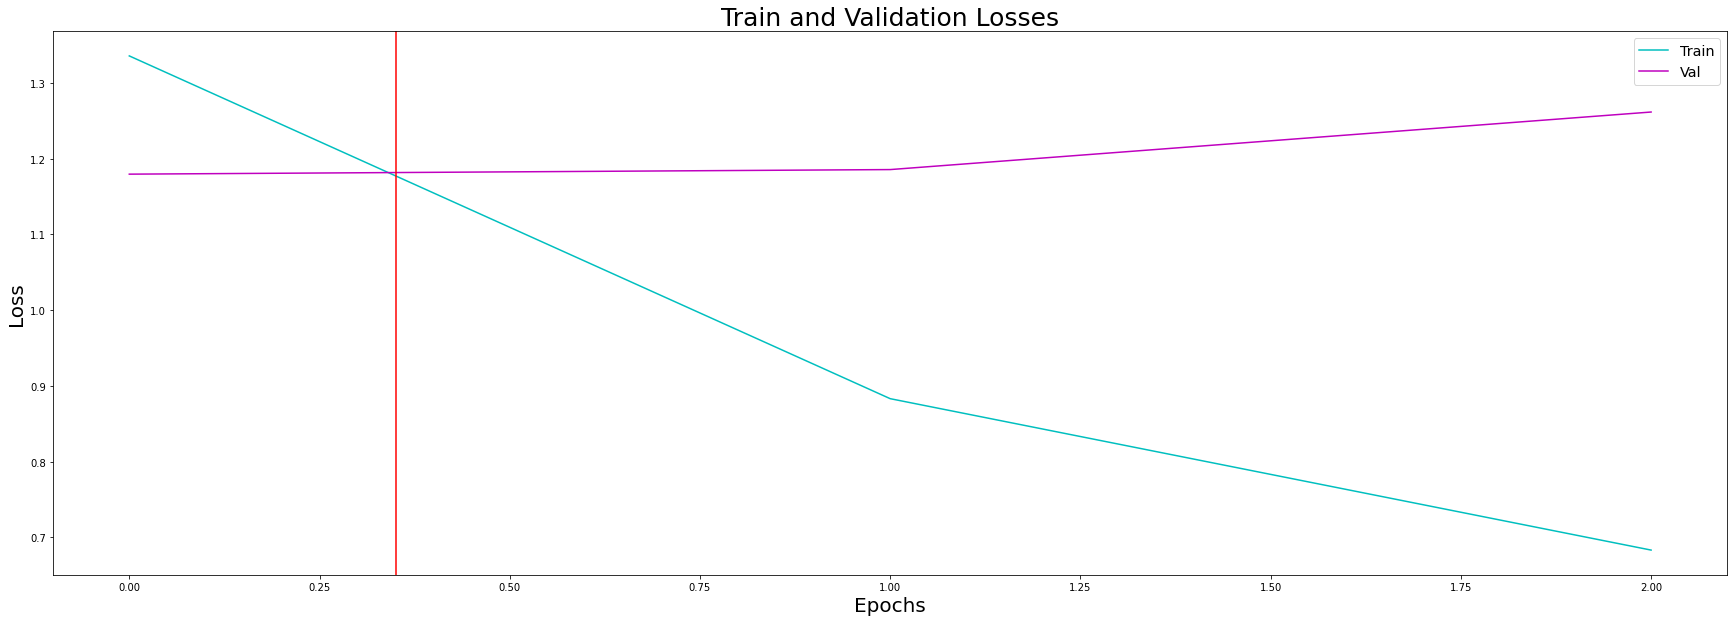

In [ ]:
train_losses_loaded = []

for i in range(last_new_epoch):
  if (i+1) % epochs == 0:
    # Load train losses
    with open('/content/drive/MyDrive/bert/train_losses'+str(i+1)+'.pkl', 'rb') as f:
      temp_list = pickle.load(f)
      for elem in temp_list:
        train_losses_loaded.append(elem)

val_losses_loaded = []

for i in range(last_new_epoch):
  if (i+1) % epochs == 0:
    # Load val losses
    with open('/content/drive/MyDrive/bert/val_losses'+str(i+1)+'.pkl', 'rb') as f:
      temp_list = pickle.load(f)
      for elem in temp_list:
        val_losses_loaded.append(elem)

fig,ax = plt.subplots(1,1,figsize=(30,10))

early_stopping = 0.35

ax.set_title("Train and Validation Losses",size=25)
ax.set_ylabel('Loss', fontsize = 20.0) 
ax.set_xlabel('Epochs', fontsize = 20) 
_=ax.plot(train_losses_loaded,'-c')
_=ax.plot(val_losses_loaded,'-m')
_=ax.axvline(x=early_stopping,color='r')
_=ax.legend(('Train','Val'),loc='upper right',fontsize='x-large')

> In this notebook we loaded bert-base-uncased model and after studying thoroughly huggingface library, we trained and 
evaluated in validation set our model gradually! Ignore evaluation script of SQuAD dataset v2, cause we didn't use it!


> As we can observe our model starts overfitting before first epoch, very quickly! We tried to reduce overfitting,
but something like this was inevitable, because our model (bert base uncased) is too complex and the 
fact that we feed model with a lot of data increases that phenomenon! As a reminder bert base uncased is too complex, 
despite the fact that this is the smallest possible bert model, which produces embeddings of size 768.

> However validation and train loss are pretty small so we decide to overcome overfitting and train for 
6 epochs our model! This wasn't so easy, due to the fact that bert model needed much time to train for only 
one epoch... In addition, we have to overcome time limit usage of Google's CUDA GPU, so we managed to 
train in packs of 3 epochs each time (approximately 9 hours of training with total usage of GPU). You can observe 
by yourself our prints above training section. In lectures's theory it suggests us to train our bert model for 3-4 epochs,
but we tried to exceed that just cause we were curious about generalization gap, without observing something not expected.

> Some possible solutions that didn't solve our overfitting problem and which we tried were: 

1. Reducing feeding data, from ~90.000 articles we reduced it to 40.000 and even 20.000, but unfortunately 
this move didn't affect training and validation losses. And obviously with less data, model has trained 
with few info so model's performance on evaluation notebook wasn't so pretty.

2. Experimenting with learning rates from big values,1e-3 to too low values, 1e-6. But, unfortunately,
phenomenon of overfitting was still here with slight differences (for example overfitting starts from 
0.5 epoch instead of 0.3 epoch. Let's just remind that based on our lectures, theory supported that some good values 
for learning rates are 5e-5,3e-5,2e-5. Our final choice was 5e-5, with which model seems to have the most 'normal' 
behavior in our learning curves.

3. Add dropout layer in the end of bert model, but suprisingly model was confused on evaluation question-answering, 
so we decided to remove it.

4. As we know from theory with small batches of training data, model is gradually learning quicker information,
so training loss keeps falling with rapid rhythm. So the first thought we had, was to try increase batch
size with a very big number like 512. But...this didn't work, cause after seconds RAM memory ran out,
so we tried to reduce to half. And so on, we reached the magic number of batch size=8. So with smallest
bert model, which produces embeddings of 764 size, we were forced to use (the greater value) batch size=8.
So this is one of the most significant factors, why we couldn't handle overfitting (memory limit usage
of Google Colab). Last but not least, in our lectures's theory is suggests that a pretty descent value for batch size is 32,
which we unfortunately couldn't experiment.Note that Google Colab provides for Pro Users extended memory and time limits 
(with GPU/TPU).

